In [44]:
from pymatgen.core import Structure
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from matplotlib import colors
from matplotlib import rcParams
%matplotlib ipympl

In [37]:
def sdm(particles, bin_size, variables=None, normalize=False, reference_point=None, reference_point_shift=False,
        box_dimensions=None, plot_mode='bar', plot=False, save=False, figure_size=(6, 6), figname='sdm',
        histogram_type='1d', axes=None):
    """
	Computes 1D or 2D histograms for a set of particle coordinates.

	Parameters
	----------
	particles : (N, 3) np.array
		Set of particle coordinates for which to compute the SDM.
	bin_size : float
		Bin size for each histogram.
	variables : variables object
	normalize : bool, optional
		Option to normalize the histograms. If True, the histogram values are normalized.
	reference_point : (3,) np.array or list, optional
		The center of the box. If left as None, there is no data cropping, and calculate the SDM for the whole data.
	reference_point_shift : bool, optional
		Option to shift the relative positions by the reference point. If True, the relative positions are shifted.
	box_dimensions : (3,) np.array or list, optional
		The dimensions of the box. If left as None, the box dimensions will be inferred from the particles.
	plot_mode : str, optional
		The plot mode for the histograms. Options are 'bar' or 'line'.
	plot : bool, optional
		Option to plot the histograms. If True, the histograms are plotted.
	save : bool, optional
		Option to save the histograms. If True, the histograms are saved.
	figure_size : (float, float), optional
		The size of the figure in inches.
	figname : str, optional
		The name of the figure.
	histogram_type : str, optional
		Type of histogram. Options are '1d' or '2d' or '3d'.
	axes : list or None, optional
		Specifies the axes for 1D or 2D histograms. For '1d', provide a list like ['x'], ['y'], or ['z'].
		For '2d', provide a list like ['x', 'y'], ['y', 'z'], or ['x', 'z'] or ['x', 'y', 'z'].

	Returns
	-------
	histograms : list of np.array
		List of 1D or 2D histograms based on user preferences.
	edges : list of np.array
		Bin edges for each histogram.
	"""

    if reference_point is not None and box_dimensions is not None:
        if isinstance(reference_point, list):
            reference_point = np.array(reference_point)
        if isinstance(box_dimensions, list):
            box_dimensions = np.array(box_dimensions)
        # Ensure box_dimensions has at least 3 components
        assert len(box_dimensions) == 3, "box_dimensions must have 3 components (x, y, z)."

        # Calculate the bounds of the box
        box_min = reference_point - 0.5 * box_dimensions
        box_max = reference_point + 0.5 * box_dimensions

        # Crop particles within the specified box
        inside_box = np.all((particles >= box_min) & (particles <= box_max), axis=1)
        particles = particles[inside_box]

    # Calculate relative positions based on user choices
    dx, dy, dz = None, None, None

    if 'x' in axes:
        dx = np.subtract.outer(particles[:, 0], particles[:, 0])
        if reference_point_shift and reference_point is not None and box_dimensions is not None:
            dx = dx + reference_point[0]

    if 'y' in axes:
        dy = np.subtract.outer(particles[:, 1], particles[:, 1])
        if reference_point_shift and reference_point is not None and box_dimensions is not None:
            dy = dy + reference_point[1]

    if 'z' in axes:
        dz = np.subtract.outer(particles[:, 2], particles[:, 2])
        if reference_point_shift and reference_point is not None and box_dimensions is not None:
            dz = dz + reference_point[2]

    histograms = []
    edges_list = []
    if 'x' in axes and 'y' in axes and 'z' in axes:
        edges = np.arange(min(np.min(dx), np.min(dy), np.min(dz)), max(np.max(dx), np.max(dy), np.max(dz)), bin_size)
    elif 'x' in axes and 'y' in axes:
        edges = np.arange(min(np.min(dx), np.min(dy)), max(np.max(dx), np.max(dy)), bin_size)
    elif 'y' in axes and 'z' in axes:
        edges = np.arange(min(np.min(dy), np.min(dz)), max(np.max(dy), np.max(dz)), bin_size)
    elif 'x' in axes and 'z' in axes:
        edges = np.arange(min(np.min(dx), np.min(dz)), max(np.max(dx), np.max(dz)), bin_size)
    elif 'x' in axes:
        edges = np.arange(np.min(dx), np.max(dx), bin_size)
    elif 'y' in axes:
        edges = np.arange(np.min(dy), np.max(dy), bin_size)
    elif 'z' in axes:
        edges = np.arange(np.min(dz), np.max(dz), bin_size)

    if histogram_type == '1d':
        if 'x' in axes:
            histo_dx, bins_dx = np.histogram(dx.flatten(), bins=edges)
            histograms.append(histo_dx)
            edges_list.append(bins_dx)
        elif 'y' in axes:
            histo_dy, bins_dy = np.histogram(dy.flatten(), bins=edges)
            histograms.append(histo_dy)
            edges_list.append(bins_dy)
        elif 'z' in axes:
            histo_dz, bins_dz = np.histogram(dz.flatten(), bins=edges)
            histograms.append(histo_dz)
            edges_list.append(bins_dz)
        else:
            raise ValueError("Invalid axes for 1D histogram. Choose from ['x'], ['y'], or ['z'].")
        if normalize:
            histograms[-1] = histograms[-1] / np.sum(histograms[-1])

    if histogram_type == '2d':
        if 'x' in axes and 'y' in axes:
            hist2d, x_edges, y_edges = np.histogram2d(dx.flatten(), dy.flatten(), bins=[edges, edges])
            extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
            histograms.append(hist2d)
            edges_list.extend([x_edges, y_edges])
        elif 'y' in axes and 'z' in axes:
            hist2d, x_edges, y_edges = np.histogram2d(dy.flatten(), dz.flatten(), bins=[edges, edges])
            extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
            histograms.append(hist2d)
            edges_list.extend([x_edges, y_edges])
        elif 'x' in axes and 'z' in axes:
            hist2d, x_edges, y_edges = np.histogram2d(dx.flatten(), dz.flatten(), bins=[edges, edges])
            extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
            histograms.append(hist2d)
            edges_list.extend([x_edges, y_edges])
        else:
            raise ValueError("Invalid axes for 2D histogram. Choose from ['x', 'y'], ['y', 'z'], or ['x', 'z'].")

        if normalize:
            histograms[-1] = histograms[-1] / np.sum(histograms[-1])

    if histogram_type == '3d':
        if 'x' in axes and 'y' in axes and 'z' in axes:
            hist3d, edges = np.histogramdd((dx.flatten(), dy.flatten(), dz.flatten()), bins=[edges, edges, edges])
            histograms.append(hist3d)
            edges_list.extend([edges])
        if normalize:
            histograms[-1] = histograms[-1] / np.sum(histograms[-1])

    if plot or save:
        # Plot histograms
        if histogram_type == '1d':
            fig, ax = plt.subplots(figsize=figure_size)
            for i, hist in enumerate(histograms):
                if plot_mode == 'bar':
                    ax.bar(edges[:-1], hist, width=bin_size, align='edge')
                    ax.set_ylabel('Counts')
                    ax.set_xlabel(f'{axes[i]} (nm)')
                elif plot_mode == 'line':
                    ax.plot(edges[:-1], hist)
                    ax.set_ylabel('Counts')
                    ax.set_xlabel(f'{axes[i]} (nm)')
        elif histogram_type == '2d':
            fig, ax = plt.subplots(figsize=figure_size)
            img = ax.imshow(histograms[-1].T, origin='lower', extent=extent,  aspect="auto")
            ax.set_ylabel(f'{axes[1]} (nm)')
            ax.set_xlabel(f'{axes[0]} (nm)')
            cmap = copy(plt.cm.plasma)
            cmap.set_bad(cmap(0))
            pcm = ax.pcolormesh(x_edges, y_edges, histograms[-1].T, cmap=cmap, norm=colors.LogNorm(), rasterized=True)
            cbar = fig.colorbar(pcm, ax=ax, pad=0)
            cbar.set_label('Counts', fontsize=10)
        elif histogram_type == '3d':
            pass

        if save and variables is not None:
            # Enable rendering for text elements
            rcParams['svg.fonttype'] = 'none'
            plt.savefig(variables.result_path + '\\sdm_{fn}.png'.format(fn=figname), format="png", dpi=600)
            plt.savefig(variables.result_path + '\\sdm_{fn}.svg'.format(fn=figname), format="svg", dpi=600)

        if plot:
            plt.show()

    return histograms, edges_list


In [203]:

def rdf(particles, dr, variables=None, rho=None, rcutoff=0.9, eps=1e-15, normalize=True, reference_point=None,
        box_dimensions=None, plot=False, save=False, figure_size=(6, 6), figname='rdf'):
	"""
	Computes 2D or 3D radial distribution function g(r) of a set of particle
	coordinates of shape (N, d). Particle must be placed in a 2D or 3D cuboidal
	box of dimensions [width x height (x depth)].

	Parameters
	----------
	particles : (N, d) np.array
		Set of particle from which to compute the radial distribution function
		g(r). Must be of shape (N, 2) or (N, 3) for 2D and 3D coordinates
		repsectively.
	dr : float
		Delta r. Determines the spacing between successive radii over which g(r)
		is computed.
	variables : variables object
	rho : float, optional
		Number density. If left as None, box dimensions will be inferred from
		the particles and the number density will be calculated accordingly.
	rcutoff : float
		radii cutoff value between 0 and 1. The default value of 0.9 means the
		independent variable (radius) over which the RDF is computed will range
		from 0 to 0.9*r_max. This removes the noise that occurs at r values
		close to r_max, due to fewer valid particles available to compute the
		RDF from at these r values.
	eps : float, optional
		Epsilon value used to find particles less than or equal to a distance
		in KDTree.
	normalize : bool, optional
		Option to normalize the RDF. If True, the RDF values are normalized.
	reference_point : (d,) np.array or list, optional
		The center of the box. If left as None, there is no data cropping and calculate the rdf for the whole data.
	box_dimensions :  (d,) np.array or list, optional
		The dimensions of the box. If left as None, the box dimensions will be inferred from the particles.
	plot : bool, optional
		Option to plot the RDF. If True, the RDF is plotted.
	save : bool, optional
		Option to save the RDF. If True, the RDF is saved.
	figure_size : (float, float), optional
		The size of the figure in inches.
	figname : str, optional
		The name of the figure.

	Returns
	-------
	g_r : (n_radii) np.array
		radial distribution function values g(r).
	radii : (n_radii) np.array
		radii over which g(r) is computed
	"""
	if reference_point is not None and box_dimensions is not None:
		if isinstance(reference_point, list):
			reference_point = np.array(reference_point)
		if isinstance(box_dimensions, list):
			box_dimensions = np.array(box_dimensions)
		# Ensure box_dimensions has at least 2 components
		assert len(box_dimensions) >= 2, "box_dimensions must have at least 2 components (x, y)."

		# If box_dimensions has 2 components, assume it's a 2D box (x, y)
		if len(box_dimensions) == 2:
			box_dimensions = np.concatenate((box_dimensions, [0]))

		# Calculate the bounds of the box
		box_min = reference_point - 0.5 * box_dimensions
		box_max = reference_point + 0.5 * box_dimensions

		# Crop particles within the specified box
		inside_box = np.all((particles >= box_min) & (particles <= box_max), axis=1)
		particles = particles[inside_box]

	mins = np.min(particles, axis=0)
	maxs = np.max(particles, axis=0)
	# translate particles such that the particle with min coords is at origin
	particles = particles - mins

	# dimensions of box
	dims = maxs - mins

	r_max = (np.min(dims) / 2) * rcutoff
	radii = np.arange(dr, r_max, dr)

	N, d = particles.shape
	if not rho:
		rho = N / np.prod(dims)  # number density

	# create a KDTree for fast nearest-neighbor lookup of particles
	tree = cKDTree(particles)

	g_r = np.zeros(shape=(len(radii)))
	for r_idx, r in enumerate(radii):
		# find all particles that are at least r + dr away from the edges of the box
		valid_idxs = np.bitwise_and.reduce(
			[(particles[:, i] - (r + dr) >= mins[i]) & (particles[:, i] + (r + dr) <= maxs[i]) for i in range(d)])
		valid_particles = particles[valid_idxs]

		# compute n_i(r) for valid particles.
		for particle in valid_particles:
			n = (tree.query_ball_point(particle, r + dr - eps, return_length=True) -
			     tree.query_ball_point(particle, r, return_length=True))
			g_r[r_idx] += n

		# normalize
		if normalize:
			n_valid = len(valid_particles)
			shell_vol = (4 / 3) * np.pi * ((r + dr) ** 3 - r ** 3) if d == 3 else np.pi * ((r + dr) ** 2 - r ** 2)
			g_r[r_idx] /= n_valid * shell_vol * rho

	if plot or save:
		# Plot RDF
		fig, ax = plt.subplots(figsize=figure_size)
		plt.plot(radii, g_r)
		plt.xlabel('Distance (nm)')
		plt.ylabel('Counts')
		if save and variables is not None:
			# Enable rendering for text elements
			rcParams['svg.fonttype'] = 'none'
			plt.savefig(variables.result_path + '\\projection_{fn}.png'.format(fn=figname), format="png", dpi=600)
			plt.savefig(variables.result_path + '\\projection_{fn}.svg'.format(fn=figname), format="svg", dpi=600)

		if plot:
			plt.show()

	return g_r, radii


In [204]:


def fft(particles, d, variables=None, normalize=False, reference_point=None,
        box_dimensions=None, plot=False, save=False, figure_size=(6, 6), figname='fft', fft_type='1d', axes=None):
    """
    Calculate the 1D, 2D, or 3D FFT of the particle positions.

    Parameters
    ----------
    particles : (N, 3) np.array
        Set of particle coordinates for which to compute the SDM.
    d : float

    variables : variables object
    normalize : bool, optional
        Option to normalize the fft. If True, the fft values are normalized.
    reference_point : (3,) np.array or list, optional
        The center of the box. If left as None, there is no data cropping, and calculate the fft for the whole data.
    box_dimensions : (3,) np.array or list, optional
        The dimensions of the box. If left as None, the box dimensions will be inferred from the particles.
    plot : bool, optional
        Option to plot the histograms. If True, the fft are plotted.
    save : bool, optional
        Option to save the histograms. If True, the fft are saved.
    figure_size : (float, float), optional
        The size of the figure in inches.
    figname : str, optional
        The name of the figure.
    fft_type : str, optional
        Type of histogram. Options are '1d' or '2d' or '3d'.
    axes : list or None, optional
        Specifies the axes for 1D or 2D histograms. For '1d', provide a list like ['x'], ['y'], or ['z'].
        For '2d', provide a list like ['x', 'y'], ['y', 'z'], or ['x', 'z'] or ['x', 'y', 'z'].

    Returns
    -------
    fft : list of np.array
        List of 1D or 2D histograms based on user preferences.
    	"""

    if reference_point is not None and box_dimensions is not None:
        if isinstance(reference_point, list):
            reference_point = np.array(reference_point)
        if isinstance(box_dimensions, list):
            box_dimensions = np.array(box_dimensions)
        # Ensure box_dimensions has at least 3 components
        assert len(box_dimensions) == 3, "box_dimensions must have 3 components (x, y, z)."

        # Calculate the bounds of the box
        box_min = reference_point - 0.5 * box_dimensions
        box_max = reference_point + 0.5 * box_dimensions

        # Crop particles within the specified box
        inside_box = np.all((particles >= box_min) & (particles <= box_max), axis=1)
        particles = particles[inside_box]

    fft_list = []
    edges_list = []
    if fft_type == '1d':
        if 'x' in axes:
            fft = np.fft.fft(particles[:, 0])
            fft = np.fft.fftshift(fft)
            fft = np.abs(fft)
            fft_list.append(fft)
        elif 'y' in axes:
            fft = np.fft.fft(particles[:, 1])
            fft = np.fft.fftshift(fft)
            fft = np.abs(fft)
            fft_list.append(fft)
        elif 'z' in axes:
            fft = np.fft.fft(particles[:, 2])
            fft = np.fft.fftshift(fft)
            fft = np.abs(fft)
            fft_list.append(fft)
        else:
            raise ValueError("Invalid axes for 1D histogram. Choose from ['x'], ['y'], or ['z'].")
        if normalize:
            fft_list[-1] = fft_list[-1] / np.max(fft_list[-1])
    if fft_type == '2d':
        if 'x' in axes and 'y' in axes:
            x, y = np.meshgrid(particles[:, 0], particles[:, 1])
            fft2d = np.fft.fft2(x)
            # Shift zero frequency components to the center
            fft2d = np.fft.fftshift(fft2d)
            amplitude = 20 * np.log(np.abs(fft2d))
            fft_list.append(amplitude)
            x_edges = np.fft.fftfreq(len(particles[:, 0]))
            y_edges = np.fft.fftfreq(len(particles[:, 1]))
            edges_list.append([x_edges, y_edges])
        elif 'y' in axes and 'z' in axes:
            y, z = np.meshgrid(particles[:, 1], particles[:, 2])
            fft2d = np.fft.fft2(y)
            # Shift zero frequency components to the center
            fft2d = np.fft.fftshift(fft2d)
            amplitude = 20 * np.log(np.abs(fft2d))
            fft_list.append(amplitude)
            y_edges = np.fft.fftfreq(len(particles[:, 1]))
            z_edges = np.fft.fftfreq(len(particles[:, 2]))
            edges_list.append([y_edges, z_edges])
        elif 'x' in axes and 'z' in axes:
            x, z = np.meshgrid(particles[:, 0], particles[:, 2])
            fft2d = np.fft.fft2(z)
            # Shift zero frequency components to the center
            fft2d = np.fft.fftshift(fft2d)
            amplitude = 20 * np.log(np.abs(fft2d))
            fft_list.append(amplitude)
            x_edges = np.fft.fftfreq(len(particles[:, 0]))
            z_edges = np.fft.fftfreq(len(particles[:, 2]))
            edges_list.append([x_edges, z_edges])
        else:
            raise ValueError("Invalid axes for 2D histogram. Choose from ['x', 'y'], ['y', 'z'], or ['x', 'z'].")

        if normalize:
            fft_list[-1] = fft_list[-1] / np.max(fft_list[-1])

    if fft_type == '3d':
        if 'x' in axes and 'y' in axes and 'z' in axes:
            pass
        if normalize:
            pass
#             fft_list[-1] = fft_list[-1] / np.max(fft_list[-1])

    if plot or save:
        # Plot histograms
        if fft_type == '1d':
            fig, ax = plt.subplots(figsize=figure_size)
            for i, fft_i in enumerate(fft_list):
                plt.plot(fft_i)
                plt.xlabel(f'{axes[i]} Frequency (Hz)')
                plt.ylabel('Amplitude')
        elif fft_type == '2d':
            fig, ax = plt.subplots(figsize=figure_size)
            plt.imshow(fft_list[-1], extent=[-1, 1, -1, 1], origin='lower', aspect="auto")
            cmap = copy(plt.cm.plasma)
            cmap.set_bad(cmap(0))
            x_edges = edges_list[-1][0]
            y_edges = edges_list[-1][1]
            pcm = ax.pcolormesh(x_edges, y_edges, fft_list[-1], cmap=cmap, norm=colors.LogNorm(), rasterized=True)
            cbar = fig.colorbar(pcm, ax=ax, pad=0)
            cbar.set_label('Counts', fontsize=10)
            plt.xlabel(f'{axes[0]} Frequency (Hz)')
            plt.ylabel(f'{axes[1]} Frequency (Hz)')
        elif fft_type == '3d':
            pass

        if save and variables is not None:
            # Enable rendering for text elements
            rcParams['svg.fonttype'] = 'none'
            plt.savefig(variables.result_path + '\\fft_{fn}.png'.format(fn=figname), format="png", dpi=600)
            plt.savefig(variables.result_path + '\\fft_{fn}.svg'.format(fn=figname), format="svg", dpi=600)

        if plot:
            plt.show()

    return fft_list

(2000, 3)


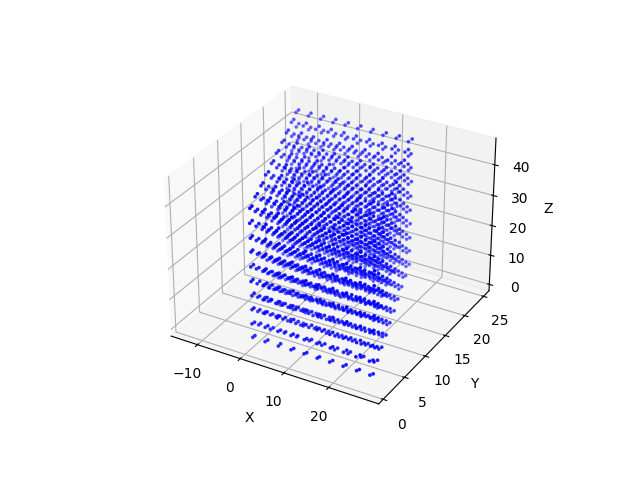

In [45]:
structure = Structure.from_file('Ti.cif')
structure.make_supercell(10)

coords = structure.cart_coords
noise = np.random.normal(loc=0.0, scale=0.05, size=(coords.shape))
coords = coords + noise
print(coords.shape)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Plot atomic positions
ax.scatter(coords[:,0], coords[:,1], coords[:,2], c='b', marker='o', s=3)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


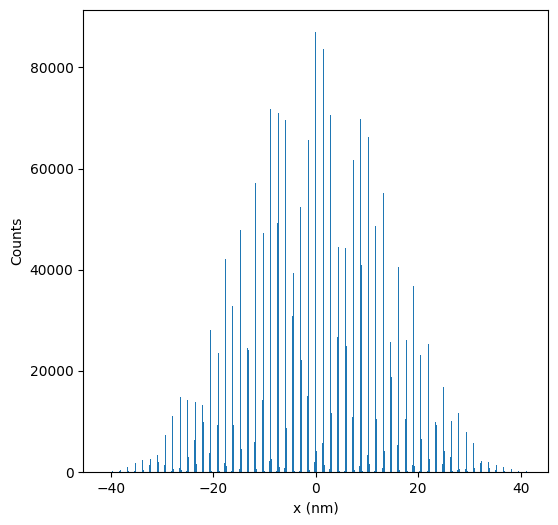

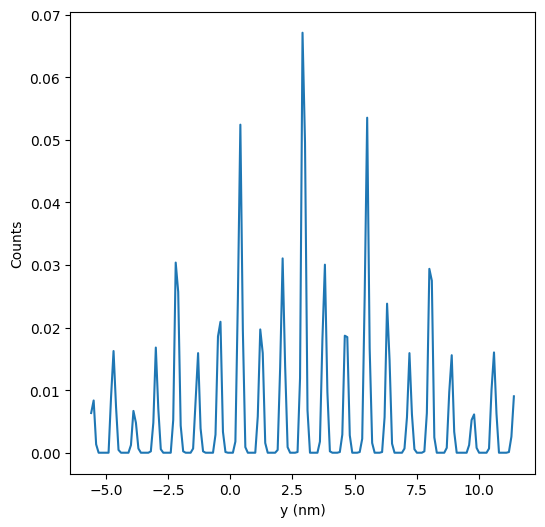

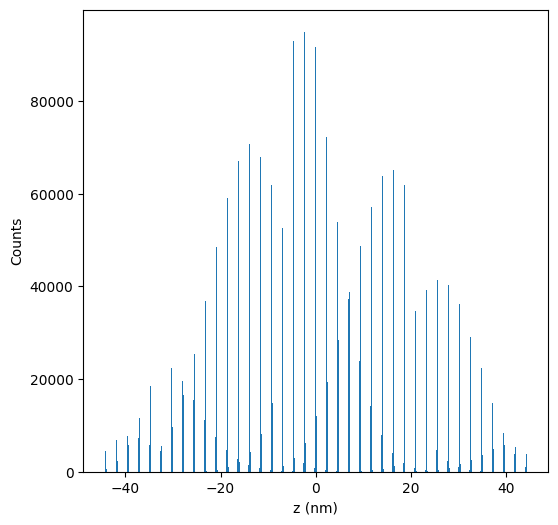

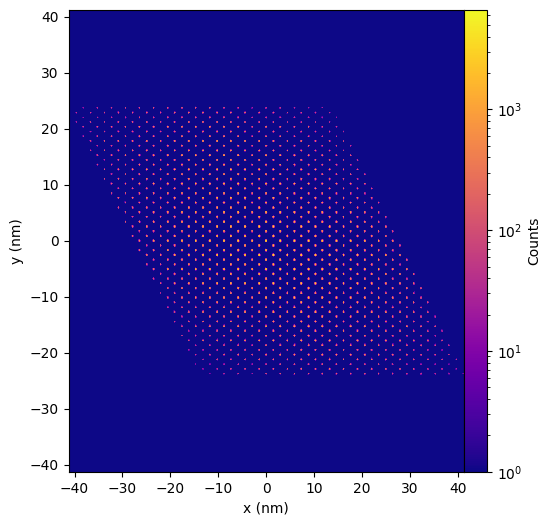

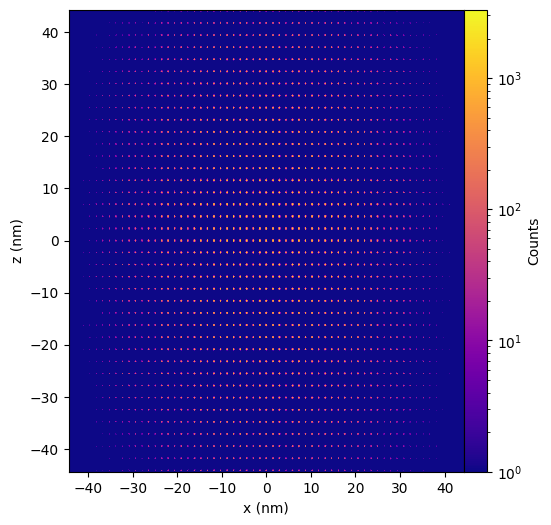

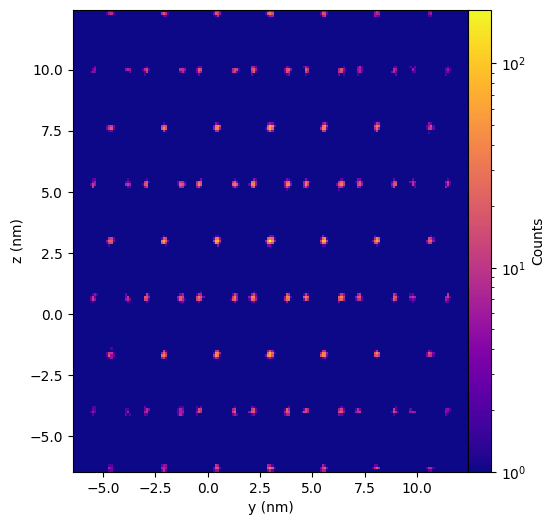

In [40]:
# compute spatial distribution map with dmax = 10 and nbins = 100
sdm_histogram, edges = sdm(coords, bin_size=0.1, variables=None, normalize=False, plot_mode='bar', plot=True,
                            histogram_type='1d', axes=['x'])
sdm_histogram, edges = sdm(coords, bin_size=0.1, variables=None, normalize=True, reference_point=[3,3,3],
                           reference_point_shift=True, box_dimensions=[15,15,15], plot_mode='line', plot=True,
                            histogram_type='1d', axes=['y'])
sdm_histogram, edges = sdm(coords, bin_size=0.1, variables=None, normalize=False, plot_mode='bar', plot=True,
                            histogram_type='1d', axes=['z'])
sdm_histogram, edges = sdm(coords, bin_size=0.1, variables=None, normalize=False, plot_mode='line', plot=True,
                            histogram_type='2d', axes=['x', 'y'])
sdm_histogram, edges = sdm(coords, bin_size=0.1, variables=None, normalize=False, plot=True,
                            histogram_type='2d', axes=['x', 'z'])
sdm_histogram, edges = sdm(coords, bin_size=0.1, variables=None, normalize=False, reference_point=[3,3,3],
                           reference_point_shift=True, box_dimensions=[15,15,15], plot_mode='line', plot=True,
                            histogram_type='2d', axes=['y', 'z'])

sdm_histogram, edges = sdm(coords, bin_size=0.1, variables=None, normalize=False, reference_point=None,
                           reference_point_shift=False, box_dimensions=None, plot_mode='line', plot=True,
                            histogram_type='3d', axes=['x', 'y', 'z'])


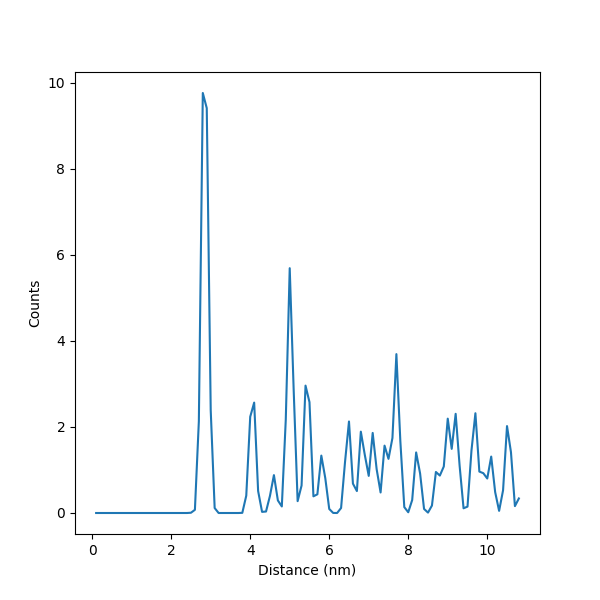

In [205]:
g_r, radii = rdf(coords, dr=0.1, variables=None, rho=None, rcutoff=0.9, eps=1e-15, normalize=True, reference_point=None,
        box_dimensions=None, plot=True, save=False, figure_size=(6, 6), figname='rdf')

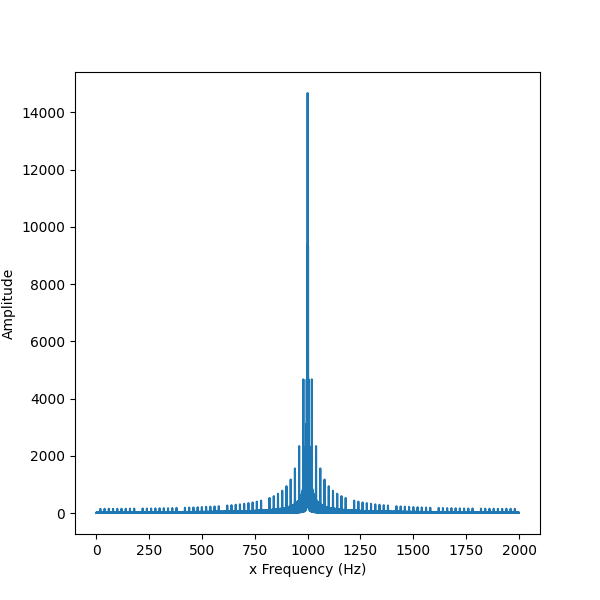

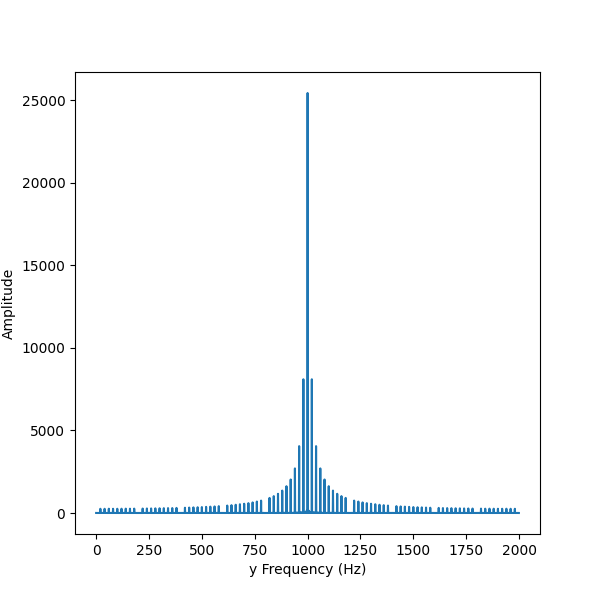

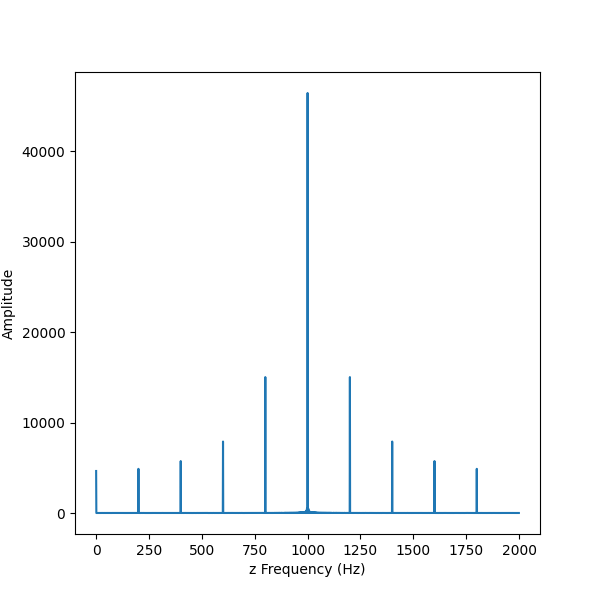

C:\Users\mehrp\AppData\Local\Temp\ipykernel_36336\3443602388.py:91: RuntimeWarning: divide by zero encountered in log
  amplitude = 20 * np.log(np.abs(fft2d))
C:\Users\mehrp\AppData\Local\Temp\ipykernel_36336\3443602388.py:151: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(x_edges, y_edges, fft_list[-1], cmap=cmap, norm=colors.LogNorm(), rasterized=True)


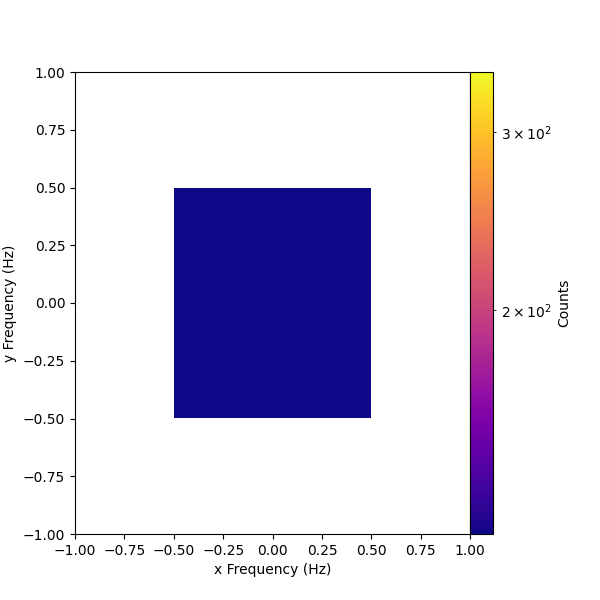

C:\Users\mehrp\AppData\Local\Temp\ipykernel_36336\3443602388.py:111: RuntimeWarning: divide by zero encountered in log
  amplitude = 20 * np.log(np.abs(fft2d))


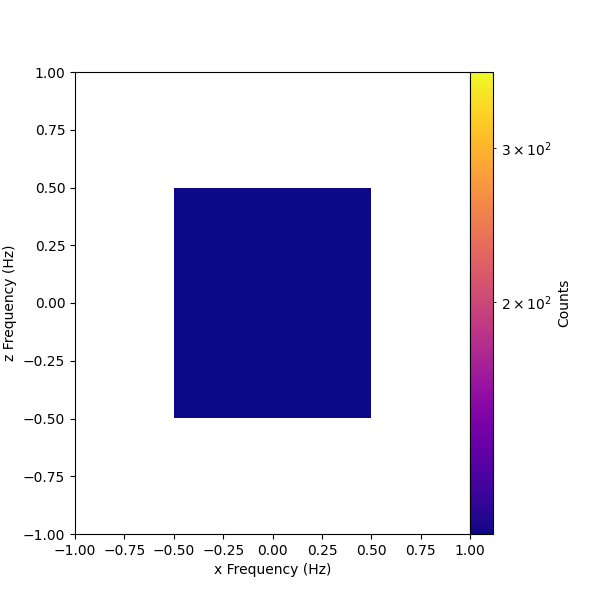

C:\Users\mehrp\AppData\Local\Temp\ipykernel_36336\3443602388.py:101: RuntimeWarning: divide by zero encountered in log
  amplitude = 20 * np.log(np.abs(fft2d))


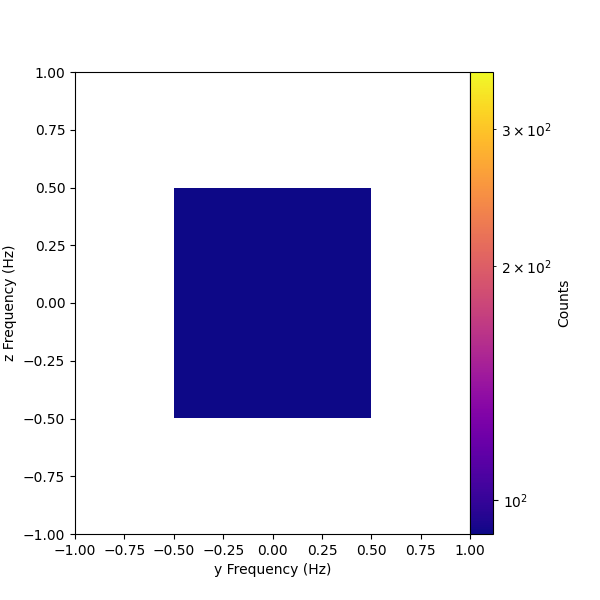

MemoryError: Unable to allocate 59.6 GiB for an array with shape (2000, 2000, 2000) and data type float64

In [201]:
fft_1 = fft(coords, d=0.1, variables=None, normalize=False, reference_point=None, reference_point_shift=False,
        box_dimensions=None, plot=True, save=False, figure_size=(6, 6), figname='fft', fft_type='1d', axes=['x'])
fft_1 = fft(coords, d=0.1, variables=None, normalize=False, reference_point=None, reference_point_shift=False,
        box_dimensions=None, plot=True, save=False, figure_size=(6, 6), figname='fft', fft_type='1d', axes=['y'])
fft_1 = fft(coords, d=0.1, variables=None, normalize=False, reference_point=None, reference_point_shift=False,
        box_dimensions=None, plot=True, save=False, figure_size=(6, 6), figname='fft', fft_type='1d', axes=['z'])
fft_1 = fft(coords, d=0.1, variables=None, normalize=False, reference_point=None, reference_point_shift=False,
        box_dimensions=None, plot=True, save=False, figure_size=(6, 6), figname='fft', fft_type='2d', axes=['x','y'])
fft_1 = fft(coords, d=0.1, variables=None, normalize=False, reference_point=None, reference_point_shift=False,
        box_dimensions=None, plot=True, save=False, figure_size=(6, 6), figname='fft', fft_type='2d', axes=['x','z'])
fft_1 = fft(coords, d=0.1, variables=None, normalize=False, reference_point=None, reference_point_shift=False,
        box_dimensions=None, plot=True, save=False, figure_size=(6, 6), figname='fft', fft_type='2d', axes=['y','z'])
fft_1 = fft(coords, d=0.1, variables=None, normalize=False, reference_point=None, reference_point_shift=False,
        box_dimensions=None, plot=True, save=False, figure_size=(6, 6), figname='fft', fft_type='3d', axes=['x','y','z'])